In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
cities = pd.read_csv('cities.csv',
                     header = None,
                     index_col = 0,
                     names=['x','y'])
cities.head()

,x,y
1,37,52
2,49,49
3,52,64
4,20,26
5,40,30


In [3]:
def generate_random_solution(df_of_cities):
    n_of_cities = len(df_of_cities)
    rand_seq = np.random.permutation(np.arange(1,n_of_cities+1))
    rand_seq = np.append(rand_seq, rand_seq[0])
    return rand_seq

In [4]:
rand_seq = generate_random_solution(cities)
rand_seq

array([46, 47, 17,  5, 35, 32, 44,  4, 40, 41, 12, 34, 14, 49, 10, 19, 22,
       28, 11, 20, 24, 37,  3, 29,  1, 39, 30,  7, 13, 45, 43,  8, 18, 25,
       21, 33, 23, 42,  6, 38, 31, 27,  2, 50, 36,  9, 48, 26, 51, 15, 16,
       46])

In [5]:
cities.loc[rand_seq].head()

,x,y
46,32,39
47,25,32
17,27,23
5,40,30
35,62,63


In [6]:
def calculate_total_distance(df_of_cities, solution):
    original = df_of_cities.loc[solution]
    shifted = original.iloc[1:].append(original.iloc[0])
    squared = (original.values - shifted.values)**2
    return np.sum(np.sqrt(np.sum(squared, axis=1)))

In [7]:
def generate_neighbour_swap(solution):
    # Select two nodes i and j at random, swap these two nodes
    # replace = False ensures that i and j are not equal
    i,j = np.random.choice(range(1,51), 2, replace=False)
    new_sol = solution.copy()
    new_sol[i], new_sol[j] = solution[j], solution[i]
    return new_sol

In [8]:
def generate_neighbour_twoopt(solution):
    #select two nodes i and j at random,invert all nodes betweeen i+1 and j
    N = len(solution)
    i = np.random.randint(0, N-3)
    # j must be at least i+2
    j = np.random.randint(i+2, N-1)
    new_sol = solution.copy()
    new_sol[i+1:j+1] = new_sol[i+1:j+1][::-1]
    return new_sol

In [42]:
def simulated_annealing(city_df, start_temp, change_thres, temp_thres, cooling_rate, neighbour_func):
    # city_df: Pandas Dataframe of city coordinates
    # start_temp: Starting temperature
    # change_thres: Threshold value for the difference between eval_n and eval_c. Required for termination condition.
    # temp_thres: Threshold value for the temperature. Required for stopping condition.
    # cooling_rate: Cooling rate used for T = T * cooling_rate
    # neighbour_func: Function to generate a solution from the neighbourhood of the current solution
    
    
    # Initialization
    t = 0
    temp = start_temp
    current_sol = generate_random_solution(city_df)
    
    # Storing objective function values for graphing. Not required.
    f_vals = []
    f_vals.append(calculate_total_distance(cities, current_sol))
    
    while temp > temp_thres:
        while True:
            # Generate neighbour solution.          
            neighbour_sol = neighbour_func(current_sol)
            
            # Evaluate current and neighbour solution.
            eval_c = calculate_total_distance(city_df, current_sol)
            eval_n = calculate_total_distance(city_df, neighbour_sol)
            
            # Keep neighbour solution if it is better.
            if eval_n < eval_c:
                current_sol = neighbour_sol
                
            # Keep worse neighbour solution with a probability.
            else:
                power = (eval_c - eval_n) / temp
                if np.random.random() < np.exp(power):
                    current_sol = neighbour_sol
            
            # Storing objective function values for graphing. Not required.
            f_vals.append(eval_c)
            
            # Exit inner loop if the difference between solutions is less than the threshold.
            if np.abs(eval_c - eval_n) <= change_thres:
                break
                
        # Update temperature and iteration counter.
        temp = temp * cooling_rate
        t += 1
    return current_sol, eval_c, f_vals, t

In [ ]:
%time best_sol, best_f, f_arr, t= simulated_annealing(cities, 100, 1, 0.1, 0.99, generate_neighbour_swap)

Wall time: 4min 26s


In [ ]:
best_sol

array([28, 28, 22,  2, 16, 50,  9, 38, 11, 32,  1,  8, 31, 26,  7, 23, 43,
       24, 14, 25,  4, 17, 45, 33, 39, 10, 29, 35, 36,  3, 20, 21, 34, 30,
       49,  5, 37, 15, 44, 42, 19, 40, 41, 13, 18, 47, 12, 46, 27, 48,  6,
       51])

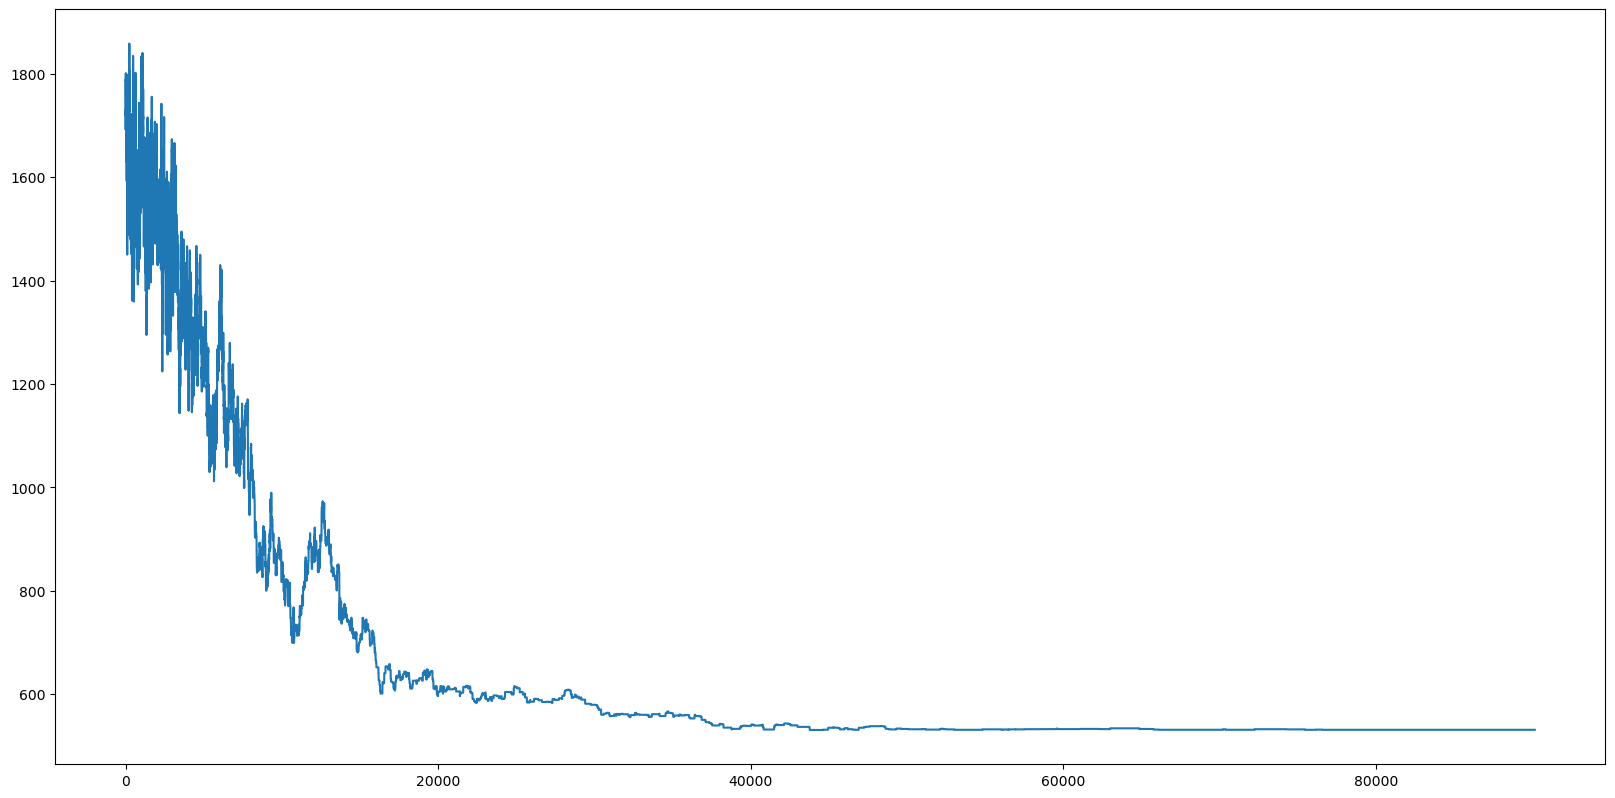

In [ ]:
plt.figure(dpi = 100, figsize=(20,10))
plt.plot(f_arr)

In [78]:
best_f

531.2153793565328

In [79]:
calculate_total_distance(cities, generate_random_solution(cities))

1788.4358996928684

In [74]:
t

135

In [16]:
%time best_sol, best_f, f_arr, t= simulated_annealing(cities, 100, 1, 0.1, 0.99, generate_neighbour_twoopt)

Wall time: 12min 32s


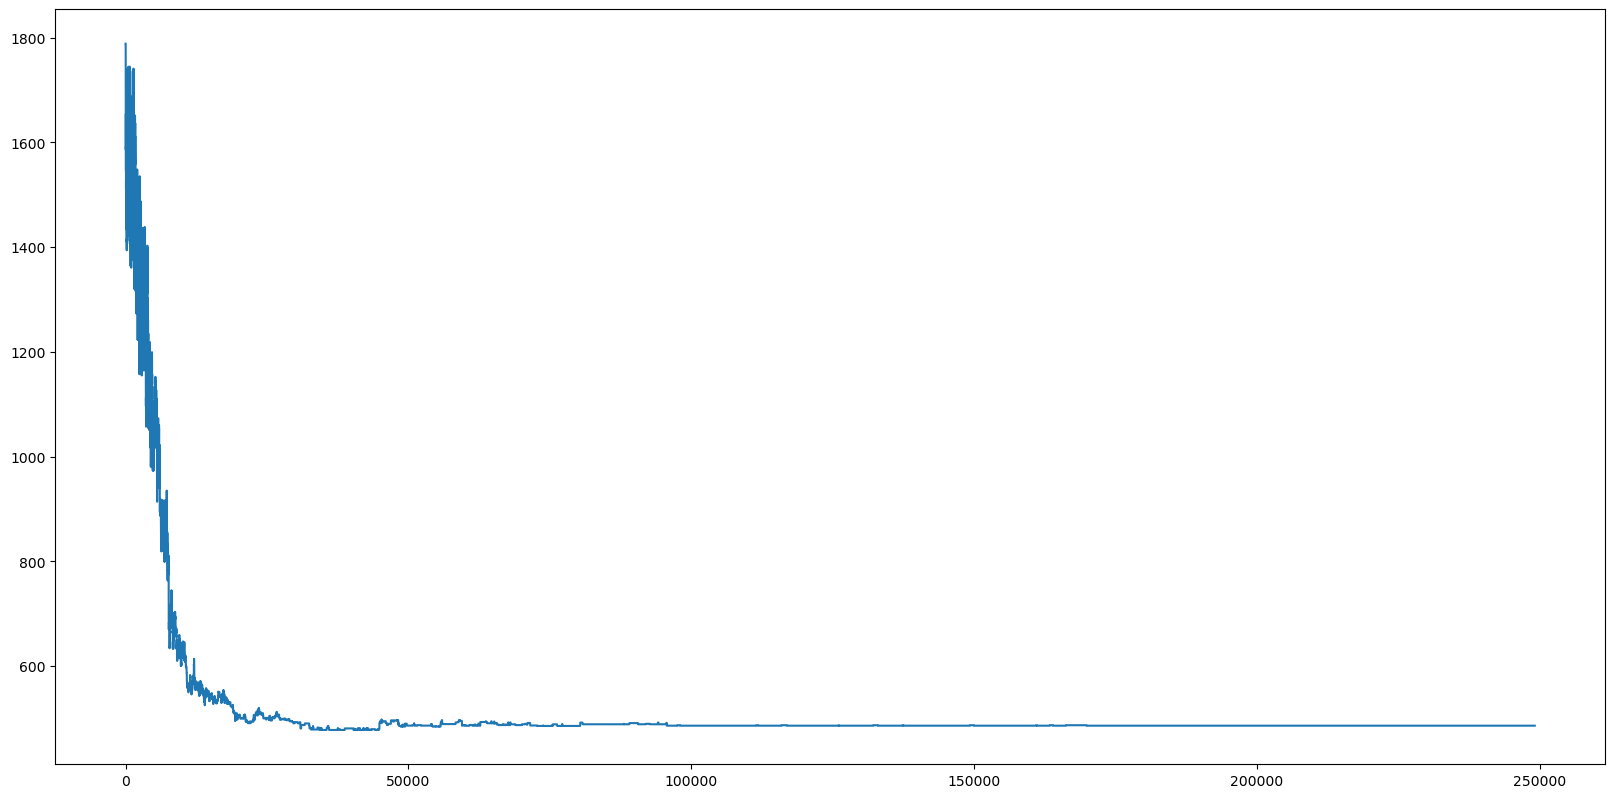

In [17]:
plt.figure(dpi = 100, figsize=(20,10))
plt.plot(f_arr)

In [18]:
best_f

486.5600290968243

In [19]:
calculate_total_distance(cities, generate_random_solution(cities))

1788.4358996928684

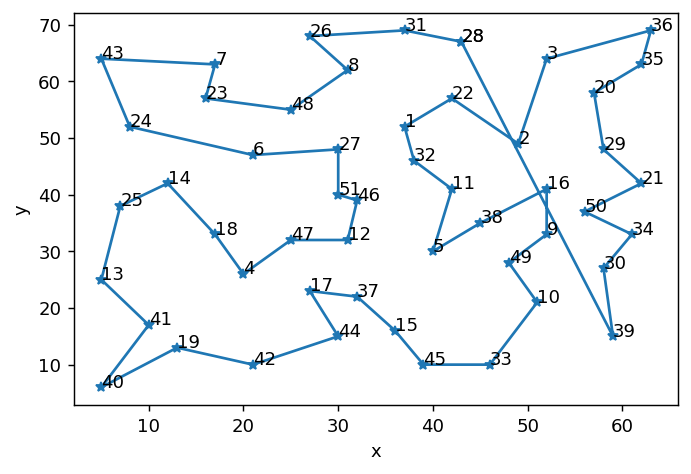

In [20]:
prev_cities = cities.loc[best_sol]

plt.figure(dpi = 130)
plt.plot(prev_cities.loc[:,'x'], prev_cities.loc[:,'y'], "-*")
plt.xlabel('x')
plt.ylabel('y')

for i in best_sol:
    plt.annotate(i, (prev_cities.drop_duplicates().loc[i,'x'], prev_cities.drop_duplicates().loc[i,'y']))

In [33]:
def different_start_temp(num_repetitions, start_temps, city_df, change_thres, temp_thres, cooling_rate):
    data = []
    for start_temp in start_temps:
        temp = []
        for i in range(num_repetitions):
            repetition = []
            
            start_time = time.time()
            test = simulated_annealing(city_df, start_temp, change_thres, temp_thres, cooling_rate, generate_neighbour_swap)[1:]
            test_lst = list(test)
            exec_time = time.time() - start_time
            test_lst[1] = len(test_lst[1])
            test_lst.append(exec_time)
            repetition.append(test_lst)
            
            start_time = time.time()
            test = simulated_annealing(city_df, start_temp, change_thres, temp_thres, cooling_rate, generate_neighbour_twoopt)[1:]
            test_lst = list(test)
            exec_time = time.time() - start_time
            test_lst[1] = len(test_lst[1])
            test_lst.append(exec_time)
            repetition.append(test_lst)
            
            temp.append(repetition)
        data.append(temp)
    
    data = np.array(data)
    sums = np.empty(shape=(len(start_temps),2,4))
    for i in range(len(start_temps)):
        for j in range(num_repetitions):
            sums[i] += data[i,j]
    means = sums / num_repetitions
    
    indices = []
    for temp in start_temps:
        indices.append(f'{temp}, Swap')
        indices.append(f'{temp}, TwoOpt')
    columns = ['Best F Value', 'Inner Loop Count', 'Outer Loop Count', 'Execution Time (s)']
    df = pd.DataFrame(np.reshape(means, (len(start_temps)*2, 4)), indices, columns)
    return df

In [20]:
different_start_temp(3, [100,250], cities, 1, 1, 0.6)

,Best F Value,Inner Loop Count,Outer Loop Count,Execution Time
"100, Swap",918.215832,517.333333,10.0,1.488911
"100, TwoOpt",859.263117,406.666667,10.0,1.188494
"250, Swap",985.019268,557.000000,11.0,1.672722
"250, TwoOpt",1016.049496,328.000000,11.0,0.971345


In [32]:
def different_cooling_rate(num_repetitions, start_temp, city_df, change_thres, temp_thres, cooling_rates):
    data = []
    for cooling_rate in cooling_rates:
        rate = []
        for i in range(num_repetitions):
            repetition = []
            
            start_time = time.time()
            test = simulated_annealing(city_df, start_temp, change_thres, temp_thres, cooling_rate, generate_neighbour_swap)[1:]
            test_lst = list(test)
            exec_time = time.time() - start_time
            test_lst[1] = len(test_lst[1])
            test_lst.append(exec_time)
            repetition.append(test_lst)
            
            start_time = time.time()
            test = simulated_annealing(city_df, start_temp, change_thres, temp_thres, cooling_rate, generate_neighbour_twoopt)[1:]
            test_lst = list(test)
            exec_time = time.time() - start_time
            test_lst[1] = len(test_lst[1])
            test_lst.append(exec_time)
            repetition.append(test_lst)
            
            rate.append(repetition)
        data.append(rate)
    
    data = np.array(data)
    sums = np.empty(shape=(len(cooling_rates),2,4))
    for i in range(len(cooling_rates)):
        for j in range(num_repetitions):
            sums[i] += data[i,j]
    means = sums / num_repetitions
    
    indices = []
    for rate in cooling_rates:
        indices.append(f'{rate}, Swap')
        indices.append(f'{rate}, TwoOpt')
    columns = ['Best F Value', 'Inner Loop Count', 'Outer Loop Count', 'Execution Time (s)']
    df = pd.DataFrame(np.reshape(means, (len(cooling_rates)*2, 4)), indices, columns)
    return df

In [19]:
different_cooling_rate(3, 100, cities, 1, 1, [0.6,0.7,0.8,0.9])

,Best F Value,Inner Loop Count,Outer Loop Count,Execution Time
"0.6, Swap",947.275157,525.000000,10.053333,1.889321
"0.6, TwoOpt",986.550706,228.333333,10.000000,0.983530
"0.7, Swap",905.581257,691.333333,13.000000,2.318692
"0.7, TwoOpt",913.206334,357.000000,13.000000,1.348705
"0.8, Swap",882.884455,987.666667,21.333333,3.181727
"0.8, TwoOpt",803.841981,492.333333,21.333333,1.747577
"0.9, Swap",676.643131,3264.666667,44.333333,9.796461
"0.9, TwoOpt",663.078497,1476.666667,44.250000,4.621716


In [31]:
def different_temp_thres(num_repetitions, start_temp, city_df, change_thres, temp_thres_arr, cooling_rate):
    data = []
    for temp_thres in temp_thres_arr:
        thres = []
        for i in range(num_repetitions):
            repetition = []
            
            start_time = time.time()
            test = simulated_annealing(city_df, start_temp, change_thres, temp_thres, cooling_rate, generate_neighbour_swap)[1:]
            test_lst = list(test)
            exec_time = time.time() - start_time
            test_lst[1] = len(test_lst[1])
            test_lst.append(exec_time)
            repetition.append(test_lst)
            
            start_time = time.time()
            test = simulated_annealing(city_df, start_temp, change_thres, temp_thres, cooling_rate, generate_neighbour_twoopt)[1:]
            test_lst = list(test)
            exec_time = time.time() - start_time
            test_lst[1] = len(test_lst[1])
            test_lst.append(exec_time)
            repetition.append(test_lst)
            
            thres.append(repetition)
        data.append(thres)
    
    data = np.array(data)
    sums = np.empty(shape=(len(temp_thres_arr),2,4))
    for i in range(len(temp_thres_arr)):
        for j in range(num_repetitions):
            sums[i] += data[i,j]
    means = sums / num_repetitions
    
    indices = []
    for thres in temp_thres_arr:
        indices.append(f'{thres}, Swap')
        indices.append(f'{thres}, TwoOpt')
    columns = ['Best F Value', 'Inner Loop Count', 'Outer Loop Count', 'Execution Time (s)']
    df = pd.DataFrame(np.reshape(means, (len(temp_thres_arr)*2, 4)), indices, columns)
    return df

In [30]:
different_temp_thres(3, 200, cities, 1, [1,10,100], 0.7)

,Best F Value,Inner Loop Count,Outer Loop Count,Execution Time
"1, Swap",961.613942,488.333333,15.0,1.424853
"1, TwoOpt",939.606447,416.333333,15.0,1.188102
"10, Swap",1280.389897,434.000000,9.0,1.246700
"10, TwoOpt",1187.263783,190.666667,9.0,0.541640
"100, Swap",1650.314494,44.666667,2.0,0.124995
"100, TwoOpt",1627.176274,46.666667,2.0,0.134686
